In [1]:
import os
import time
import random
import glob
import numpy as np

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
torch.__version__

'2.5.1+cpu'

In [2]:
###====================== HYPER-PARAMETERS ===========================###
## Adam
batch_size = 5  
lr_v = 2e-4
tot_sample= 100  # Totall traning images

# create folders to save result images and trained models
save_dir = "samples"
checkpoint_dir = "models"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [5]:
import h5py
import torch
from torch.utils.data import DataLoader, Dataset

class SoilMoistureDataset(Dataset):
    def __init__(self, h5_path, data_part='train'):
        self.path = h5_path
        self.data_part = data_part
        with h5py.File(self.path, mode='r') as f:
            self.data_LR = f['lr_' + self.data_part][:, 0,...]
            self.data_HR = f['hr_' + self.data_part][:, 0,...]
            
        print("高分辨率数据形状:", self.data_HR.shape)
        # 查看高分辨率数据的像素值范围（假设数据维度情况合适可这样查看）
        min_value_HR = np.min(self.data_HR)
        max_value_HR = np.max(self.data_HR)
        print("高分辨率数据像素值范围: [{}, {}]".format(min_value_HR, max_value_HR))
        print("低分辨率数据形状:", self.data_LR.shape)
        min_value_LR = np.min(self.data_LR)
        max_value_LR = np.max(self.data_LR)
        print("低分辨率数据像素值范围: [{}, {}]".format(min_value_LR, max_value_LR))
        
        # 归一化高分辨率数据
        self.data_HR = (self.data_HR - np.min(self.data_HR)) / (np.max(self.data_HR) - np.min(self.data_HR))
        self.data_LR = (self.data_LR - np.min(self.data_LR)) / (np.max(self.data_LR) - np.min(self.data_LR))
        min_value_LR = np.min(self.data_LR)
        max_value_LR = np.max(self.data_LR)
        print("归一化像素：[{}, {}]".format(min_value_LR, max_value_LR))

    def __len__(self):
        return len(self.data_LR)

    def __getitem__(self, idx):
        # 获取低分辨率数据并转换为torch.Tensor类型，同时调整维度顺序为 (height, width, channels)
        lr_data = torch.from_numpy(self.data_LR[idx].astype(np.float32)).unsqueeze(2).permute(1, 0, 2)
        # 获取高分辨率数据并转换为torch.Tensor类型，同时调整维度顺序为 (height, width, channels)，使用归一化后的数据
        hr_data = torch.from_numpy(self.data_HR[idx].astype(np.float32)).unsqueeze(2).permute(1, 0, 2)

        return hr_data, lr_data

    def get_all_data(self):
        all_hr_data = []
        all_lr_data = []
        for idx in range(self.__len__()):
            hr_data, lr_data = self.__getitem__(idx)
            all_hr_data.append(hr_data.numpy())
            all_lr_data.append(lr_data.numpy())

        all_hr_data = np.array(all_hr_data)
        all_lr_data = np.array(all_lr_data)

        return all_hr_data, all_lr_data


h5_path = r"F:\Soil_moisture_dataset\Soil_moisture_dataset\Soil_moisture_dataset.h5"
train_dataset = SoilMoistureDataset(h5_path, data_part='train')
HR_train, LR_train = train_dataset.get_all_data()
print(HR_train.shape, LR_train.shape)
val_dataset = SoilMoistureDataset(h5_path, data_part='val')
HR_val, LR_val = val_dataset.get_all_data()
print(HR_val.shape, LR_val.shape)
test_dataset = SoilMoistureDataset(h5_path, data_part='test')
HR_test, LR_test = test_dataset.get_all_data()
print(HR_test.shape, LR_test.shape)

高分辨率数据形状: (33004, 60, 60)
高分辨率数据像素值范围: [0.018158115446567535, 0.4796583354473114]
低分辨率数据形状: (33004, 10, 10)
低分辨率数据像素值范围: [0.024997945874929428, 0.44446346163749695]
归一化像素：[0.0, 1.0]
(33004, 60, 60, 1) (33004, 10, 10, 1)
高分辨率数据形状: (7072, 60, 60)
高分辨率数据像素值范围: [0.02345988340675831, 0.4792209267616272]
低分辨率数据形状: (7072, 10, 10)
低分辨率数据像素值范围: [0.024998188018798828, 0.43146541714668274]
归一化像素：[0.0, 1.0]
(7072, 60, 60, 1) (7072, 10, 10, 1)
高分辨率数据形状: (7073, 60, 60)
高分辨率数据像素值范围: [0.021717315539717674, 0.4816555380821228]
低分辨率数据形状: (7073, 10, 10)
低分辨率数据像素值范围: [0.02499997243285179, 0.4709904193878174]
归一化像素：[0.0, 1.0]
(7073, 60, 60, 1) (7073, 10, 10, 1)


In [6]:
f, ax= plt.subplots(1,2, figsize=(16, 6))
ax[0].imshow(LR_train[527], aspect='auto')
ax[1].imshow(HR_train[527], aspect='auto')
plt.show()

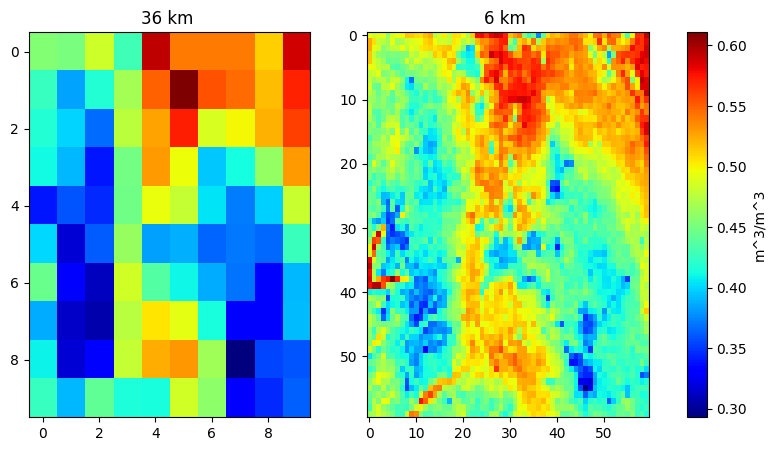

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
clim_data = [np.min(LR_train[527]),np.max(LR_train[527])]

im1 = axes[0].imshow(LR_train[527], cmap='jet', aspect='auto', clim=clim_data )
axes[0].set_title('36 km ')

clim_data = [np.min(HR_train[527]),np.max(HR_train[527])]
im2 = axes[1].imshow(HR_train[527], cmap='jet', aspect='auto', clim=clim_data )
axes[1].set_title('6 km ')

plt.colorbar(im1, ax=axes, label='m^3/m^3')
plt.show()

In [65]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add,\
                                    BatchNormalization, Activation, LeakyReLU, Layer

from tensorflow.keras.models import Model

In [66]:
class SubpixelConv2D(Layer):
    def __init__(self, upsampling_factor=2, **kwargs):
        super(SubpixelConv2D, self).__init__(**kwargs)
        self.upsampling_factor = upsampling_factor
        
    def build(self, input_shape):
        last_dim = input_shape[-1]
        factor = self.upsampling_factor * self.upsampling_factor
        if last_dim % (factor) != 0:
            raise ValueError('Channel ' + str(last_dim) + ' should be of '
                             'integer times of upsampling_factor^2: ' +
                             str(factor) + '.')

    def call(self, inputs, **kwargs):
        return tf.nn.depth_to_space( inputs, self.upsampling_factor )

    def get_config(self):
        config = { 'upsampling_factor': self.upsampling_factor, }
        base_config = super(SubpixelConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def compute_output_shape(self, input_shape):
        factor = self.upsampling_factor * self.upsampling_factor
        input_shape_1 = None
        if input_shape[1] is not None:
            input_shape_1 = input_shape[1] * self.upsampling_factor
        input_shape_2 = None
        if input_shape[2] is not None:
            input_shape_2 = input_shape[2] * self.upsampling_factor
        dims = [ input_shape[0],
                 input_shape_1,
                 input_shape_2,
                 int(input_shape[3]/factor)
               ]
        return tuple( dims )

In [152]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, add,\
                                    BatchNormalization, Activation, LeakyReLU, Layer

from tensorflow.keras.models import Model

# Generator
def get_G(input_shape):
    # 调整初始化器
    g_init = tf.random_normal_initializer(1., 0.02)
    relu = Activation('relu')

    # 根据新的输入形状调整输入层
    nin = Input(shape=input_shape)
    n = Conv2D(64, (3, 3), padding='SAME', activation='relu',
               kernel_initializer='HeNormal')(nin)
    temp = n

    # B residual blocks
    for i in range(3):
        nn = Conv2D(64, (3, 3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn = BatchNormalization(gamma_initializer=g_init)(nn)
        nn = relu(nn)
        nn = Conv2D(64, (3, 3), padding='SAME', kernel_initializer='HeNormal')(n)
        nn = BatchNormalization(gamma_initializer=g_init)(nn)

        nn = Add()([n, nn])
        n = nn

    n = Conv2D(64, (3, 3), padding='SAME', kernel_initializer='HeNormal')(n)
    n = BatchNormalization(gamma_initializer=g_init)(n)
    n = Add()([n, temp])
    # B residual blacks end

    # 在SubpixelConv2D之前添加这一层来调整通道数
    n = Conv2D(288, (3, 3), padding='SAME', kernel_initializer='HeNormal')(n)
    n = SubpixelConv2D(upsampling_factor=6)(n)  # 根据尺寸变化调整上采样因子，从10到60大概是6倍关系
    n = relu(n)

    # 调整输出层通道数为1（根据你的图像通道为1来调整）
    nn = Conv2D(1, (1, 1), padding='SAME', kernel_initializer='HeNormal', activation='tanh')(n)

    G = Model(inputs=nin, outputs=nn, name="generator")
    return G

# discriminator
def get_D(input_shape):
    g_init = tf.random_normal_initializer(1., 0.02)
    ly_relu = LeakyReLU(alpha=0.2)
    df_dim = 16

    nin = Input(input_shape)
    n = Conv2D(64, (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(nin)
    n = ly_relu(n)

    # 根据新尺寸适当调整循环次数等参数，确保卷积操作合理处理数据维度
    for i in range(2, 4):
        n = Conv2D(df_dim * (2 ** i), (4, 4), (2, 2), padding='SAME', kernel_initializer='HeNormal')(n)
        n = ly_relu(n)
        n = BatchNormalization(gamma_initializer=g_init)(n)

    n = Conv2D(df_dim * 16, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n = ly_relu(n)
    n = BatchNormalization(gamma_initializer=g_init)(n)

    n = Conv2D(df_dim * 8, (1, 1), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n = BatchNormalization(gamma_initializer=g_init)(n)
    temp = n

    n = Conv2D(df_dim * 4, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n = ly_relu(n)
    n = BatchNormalization(gamma_initializer=g_init)(n)

    n = Conv2D(df_dim * 8, (3, 3), (1, 1), padding='SAME', kernel_initializer='HeNormal')(n)
    n = BatchNormalization(gamma_initializer=g_init)(n)

    n = Add()([n, temp])

    n = Flatten()(n)
    no = Dense(units=1, kernel_initializer='HeNormal', activation='sigmoid')(n)
    D = Model(inputs=nin, outputs=no, name="discriminator")

    return D


# VGG19
def get_vgg19():
    from tensorflow.keras.layers import Lambda

    def expand_channels(x):
        """
        将单通道数据扩展为三通道数据
        """
        return tf.tile(x, [1, 1, 1, 3])

    # 根据新的输入形状调整输入参数，但这里先按照三通道要求设置形状，后续再处理实际输入的单通道数据
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet',
                                      input_tensor=None, input_shape=(60, 60, 3),  # 设置为三通道形式
                                      pooling=None, classes=1000, classifier_activation='softmax')

    inp = Input(shape=(60, 60, 1))
    x = Lambda(expand_channels)(inp)  # 通过Lambda层调用函数来扩展通道
    for ly in vgg.layers[1:17]:
        x = ly(x)
    VGG19 = Model(inp, x)

    return VGG19

In [177]:
G = get_G((10, 10, 1))
D = get_D((60, 60, 1))
vgg = get_vgg19()

In [178]:
# Optimizers
g_optimizer_init = tf.optimizers.Adam(lr_v)
g_optimizer = tf.optimizers.Adam(lr_v)
d_optimizer = tf.optimizers.Adam(lr_v)

In [179]:
n_epoch = 15
n_epoch_init = 15
n_step_epoch = round(n_epoch_init // batch_size)
img = LR_train[527]
for epoch in range(n_epoch_init):
    i,j= ((epoch)*batch_size)%tot_sample, (((epoch+1))*batch_size)%tot_sample
    if j== 0:
        j= -1
    X, Y= LR_train[i: j], HR_train[i: j]
    with tf.GradientTape() as tape:
        ypred= G(X)
        mse_loss= tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(Y, ypred), axis=-1))
        grad = tape.gradient(mse_loss, G.trainable_weights)
        g_optimizer_init.apply_gradients(zip(grad, G.trainable_weights))
        
    print("Epoch: [{}/{}] step: mse: {:.3f} ".format(epoch, n_epoch_init , mse_loss))
    if epoch%10 ==0:
        img = G.predict(LR_train[np.newaxis, 527])[0]
        print(img.shape)
        min_value = np.min(img)
        max_value = np.max(img)
        print(min_value)
        print(max_value)
#         img = (img - min_value) / (max_value - min_value)
        img = np.uint8(img * 255)

        # 将三维数组转换为二维数组
        img = img.squeeze()
        print(img.shape)
        # 现在 img 是二维的，可以直接使用 'L' 模式
        img = Image.fromarray(img, 'L')
        img.save(os.path.join(save_dir, 'init_g_{}.png'.format(epoch)))


Epoch: [0/15] step: mse: 0.431 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
(60, 60, 1)
-0.9974204
1.0
(60, 60)
Epoch: [1/15] step: mse: 0.346 
Epoch: [2/15] step: mse: 0.251 
Epoch: [3/15] step: mse: 0.230 
Epoch: [4/15] step: mse: 0.205 
Epoch: [5/15] step: mse: 0.171 
Epoch: [6/15] step: mse: 0.213 
Epoch: [7/15] step: mse: 0.191 
Epoch: [8/15] step: mse: 0.130 
Epoch: [9/15] step: mse: 0.133 
Epoch: [10/15] step: mse: 0.130 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(60, 60, 1)
-0.8061945
0.9998808
(60, 60)
Epoch: [11/15] step: mse: 0.075 
Epoch: [12/15] step: mse: 0.145 
Epoch: [13/15] step: mse: 0.102 
Epoch: [14/15] step: mse: 0.104 


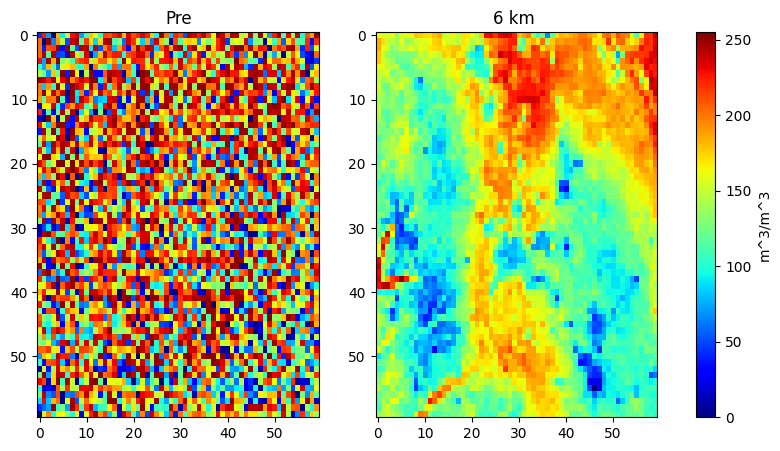

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
clim_data = [np.min(img),np.max(img)]

im1 = axes[0].imshow(img, cmap='jet', aspect='auto', clim=clim_data )
axes[0].set_title('Pre')

clim_data = [np.min(HR_train[527]),np.max(HR_train[527])]
im2 = axes[1].imshow(HR_train[527], cmap='jet', aspect='auto', clim=clim_data )
axes[1].set_title('6 km ')

plt.colorbar(im1, ax=axes, label='m^3/m^3')
plt.show()

In [181]:
n_epoch= 10
for epoch in range(n_epoch):
        i,j= ((epoch)*batch_size)%tot_sample, (((epoch+1))*batch_size)%tot_sample
        if j== 0:
            j= -1
        X, Y= LR_train[i: j], HR_train[i: j]
        with tf.GradientTape(persistent=True) as tape:
            fake_img= G(X)
            fake_logits= D(fake_img)
            real_logits= D(Y)
            fake_feature= vgg(fake_img)
            real_feature= vgg(Y)

            #D. loss
            d_loss1= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits , tf.zeros_like(fake_logits)))
            d_loss2= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(real_logits,tf.ones_like(real_logits)))
            d_loss= d_loss1 + d_loss2
            
            #G. loss
            g_gan_loss= 2e-3*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(fake_logits , tf.ones_like(fake_logits)))
            mse_loss=  2e-1* tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_img, Y), axis=-1))
            vgg_loss = 2e-6 * tf.reduce_mean(tf.reduce_mean(tf.math.squared_difference(fake_feature, real_feature), axis=-1))
            g_loss = mse_loss + vgg_loss + g_gan_loss

            grad = tape.gradient(g_loss, G.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, G.trainable_weights))
            grad = tape.gradient(d_loss, D.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, D.trainable_weights))

        print("Epoch: [{}/{}] step: D.loss: {:.3f}: G.loss: {:.3f}".format(
                epoch, n_epoch , d_loss, g_loss))


        if epoch%20 ==0:
            img = G.predict(LR_train[np.newaxis, 527])[0]
            print(img.shape)
            min_value = np.min(img)
            max_value = np.max(img)
            print(min_value)
            print(max_value)
            img = (img - min_value) / (max_value - min_value)
            img = np.uint8(img * 255)

            # 将三维数组转换为二维数组
            img = img.squeeze()
            print(img.shape)
            # 现在 img 是二维的，可以直接使用 'L' 模式
            img = Image.fromarray(img, 'L')
            img.save(os.path.join(save_dir, 'train_g_{}.png'.format(epoch)))

Epoch: [0/10] step: D.loss: 1.093: G.loss: 0.022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(60, 60, 1)
-0.64749604
0.99939674
(60, 60)
Epoch: [1/10] step: D.loss: 1.007: G.loss: 0.022
Epoch: [2/10] step: D.loss: 1.012: G.loss: 0.017
Epoch: [3/10] step: D.loss: 1.009: G.loss: 0.017
Epoch: [4/10] step: D.loss: 1.008: G.loss: 0.014
Epoch: [5/10] step: D.loss: 1.010: G.loss: 0.012
Epoch: [6/10] step: D.loss: 1.006: G.loss: 0.018
Epoch: [7/10] step: D.loss: 1.006: G.loss: 0.014
Epoch: [8/10] step: D.loss: 1.006: G.loss: 0.009
Epoch: [9/10] step: D.loss: 1.006: G.loss: 0.010


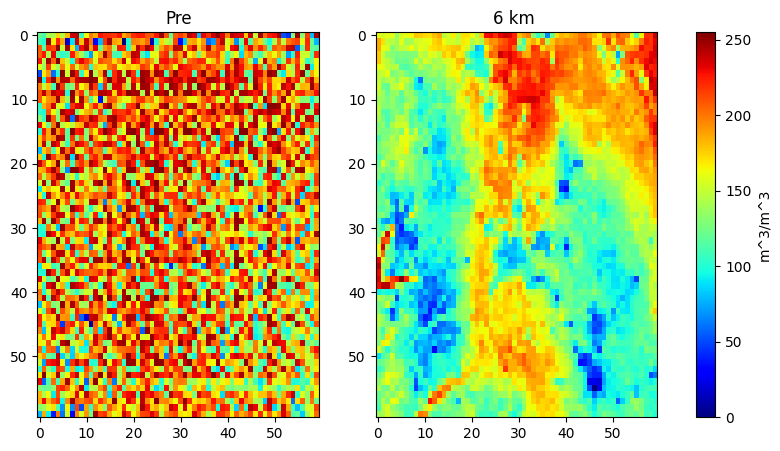

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
clim_data = [np.min(img),np.max(img)]

im1 = axes[0].imshow(img, cmap='jet', aspect='auto', clim=clim_data )
axes[0].set_title('Pre')

clim_data = [np.min(HR_train[527]),np.max(HR_train[527])]
im2 = axes[1].imshow(HR_train[527], cmap='jet', aspect='auto', clim=clim_data )
axes[1].set_title('6 km ')

plt.colorbar(im1, ax=axes, label='m^3/m^3')
plt.show()